In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read_csv("players.csv")|>
    select(-hashedEmail, -name, -gender)

head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,Age
<chr>,<lgl>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Amateur,TRUE,0.0,17


In [3]:
players_data$experience <- factor(players_data$experience,
                             levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                             labels = c(1, 2, 3, 4, 5))

head(players_data)

experience,subscribe,played_hours,Age
<fct>,<lgl>,<dbl>,<dbl>
5,TRUE,30.3,9
4,TRUE,3.8,17
4,FALSE,0.0,17
2,TRUE,0.7,21
3,TRUE,0.1,21
2,TRUE,0.0,17


In [4]:
players <- players_data|>
    mutate(experience = as.numeric(experience))

head(players)

experience,subscribe,played_hours,Age
<dbl>,<lgl>,<dbl>,<dbl>
5,TRUE,30.3,9
4,TRUE,3.8,17
4,FALSE,0.0,17
2,TRUE,0.7,21
3,TRUE,0.1,21
2,TRUE,0.0,17


In [5]:
averages <- players|>
    summarize(avg_hrs = mean(played_hours, na.rm = TRUE), avg_age = mean(Age, na.rm = TRUE), avg_exp = mean(experience, na.rm = TRUE))
averages

avg_hrs,avg_age,avg_exp
<dbl>,<dbl>,<dbl>
5.845918,21.13918,2.709184


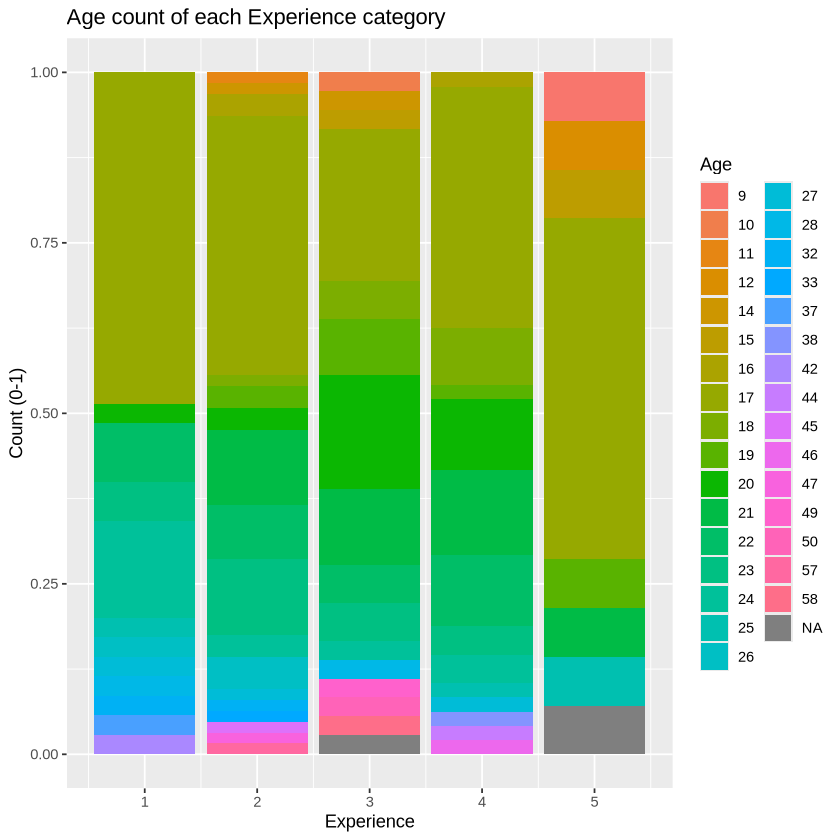

In [6]:
age_groups <- players |> 
    arrange(Age) |> 
    mutate(Age = as_factor(Age)) |>
    count(experience, Age)

age_exp_plot <- ggplot(age_groups, aes(x = experience, y = n, fill = Age)) + 
    geom_bar(stat = "identity", position = "fill") + 
    labs(x = "Experience", y = "Count (0-1)", fill = "Age", title = "Age count of each Experience category")
age_exp_plot